In [1]:
# to use GPU 
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

11.7
True


In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 32
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [2]:
#@save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [3]:
def evaluate_accuracy(net, data_iter, devices=None):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  # Set the model to evaluation mode
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if devices is not None:
                # Use the first device in the list for this example
                X, y = X.to(devices[0]), y.to(devices[0])
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    net.train()  # Set the model back to training mode
    return acc_sum / n

## BiRNN

In [4]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully-connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        outs = self.decoder(encoding)
        return outs


In [16]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()

def init_weights(m):
    if isinstance(m, (nn.Linear, nn.GRUCell)):
        if hasattr(m, 'weight'):
            nn.init.xavier_uniform_(m.weight)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.LSTM):
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
    elif isinstance(m, nn.GRU):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)

TokenEmbedding GPU

In [8]:
import os

In [9]:
# class that use GPU
#@save
class TokenEmbedding:
    """Token Embedding."""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec).cuda() # move tensor to the GPU

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [10]:
# GloVe embeddings of dimension 50, 100, and 300
# 'glove.6b.50d' , 'glove.6b.100d' , 'glove.42b.300d'
# fastText embeddings : 'wiki.en'

GLoVE

In [6]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d') # no move to GPU because of a problem with WSL
embeds_glove = glove_embedding[vocab.idx_to_token]
embeds_glove.shape

torch.Size([49346, 100])

In [12]:
net_glove = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [13]:
net_glove.apply(init_weights);

In [14]:
net_glove.embedding.weight.data.copy_(embeds_glove)
net_glove.embedding.weight.requires_grad = False

loss 0.335, train acc 0.855, test acc 0.832
174.1 examples/sec on [device(type='cuda', index=0)]


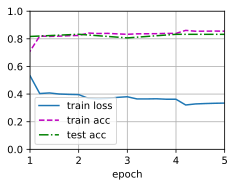

In [15]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net_glove.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net_glove, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [16]:
predict_sentiment(net_glove, vocab, 'this movie is so great')

'positive'

In [17]:
predict_sentiment(net_glove, vocab, 'this movie is so bad')

'negative'

FastText

In [18]:
#@save
class LocalTokenEmbedding:
    """Local Token Embedding."""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = embedding_name
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(data_dir, 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

after the installation of fastText : https://fasttext.cc/docs/en/support.html#building-fasttext-python-module

download cc.en.300.bin.gz : https://fasttext.cc/docs/en/crawl-vectors.html#download-directly-with-command-line-or-from-python:~:text=Download%20directly%20with%20command%20line%20or%20from%20python

adapt the dimension to 100 : https://fasttext.cc/docs/en/crawl-vectors.html#download-directly-with-command-line-or-from-python:~:text=10%0AQuery%20word%3F-,Adapt%20the%20dimension,-The%20pre%2Dtrained

and obtain VEC file from the BIN file with this code: https://stackoverflow.com/questions/58337469/how-to-save-fasttext-model-in-vec-format/58342618#58342618:~:text=15-,To%20obtain%20VEC%20file,-%2C%20containing%20merely%20all

In [19]:
fast_embedding = LocalTokenEmbedding('cc.en.100.vec') # use local path of the file instead of URL
embeds_fast = fast_embedding[vocab.idx_to_token]
embeds_fast.shape

torch.Size([49346, 100])

In [20]:
net_fast = BiRNN(len(vocab), embed_size, num_hiddens, num_layers) # change embed_size to 300 to correspond with size of wiki-news-300d-1M.vec

In [21]:
net_fast.apply(init_weights);

In [22]:
net_fast.embedding.weight.data.copy_(embeds_fast)
net_fast.embedding.weight.requires_grad = False

loss 0.302, train acc 0.870, test acc 0.862
162.5 examples/sec on [device(type='cuda', index=0)]


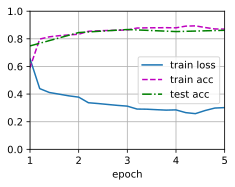

In [23]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net_fast.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net_fast, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [24]:
predict_sentiment(net_fast, vocab, 'this movie is so great')

'positive'

In [25]:
predict_sentiment(net_fast, vocab, 'this movie is so bad')

'negative'

Word2Vec

In [26]:
from gensim.models import KeyedVectors
import numpy as np

class WordTokenEmbedding:
    """Token Embedding adaptado para Word2Vec."""
    def __init__(self, embedding_file):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_file)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_file):
        idx_to_token, idx_to_vec = ['<unk>'], []
        word2vec_model = KeyedVectors.load_word2vec_format(embedding_file, binary=True)

        for word in word2vec_model.key_to_index:
            idx_to_token.append(word)
            idx_to_vec.append(word2vec_model[word])

        idx_to_vec = np.array([[0]*word2vec_model.vector_size] + idx_to_vec)
        return idx_to_token, torch.tensor(idx_to_vec).cuda()  # move tensor to the GPU

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx) for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [27]:
word_embedding = WordTokenEmbedding('40/model.bin') 
embeds_word = word_embedding[vocab.idx_to_token]
embeds_word.shape

torch.Size([49346, 100])

In [28]:
net_word = BiRNN(len(vocab), embed_size, num_hiddens,
                 num_layers)  

In [29]:
net_word.apply(init_weights)
net_word.embedding.weight.data.copy_(embeds_word)
net_word.embedding.weight.requires_grad = False

In [30]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net_word.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

loss 0.277, train acc 0.886, test acc 0.857
173.6 examples/sec on [device(type='cuda', index=0)]


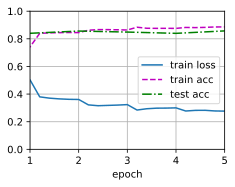

In [31]:
d2l.train_ch13(net_word, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [32]:
predict_sentiment(net_word, vocab, 'this movie is so great')

'positive'

In [33]:
predict_sentiment(net_word, vocab, 'this movie is so bad')

'negative'

In [34]:
# Evaluate and compare performance on the test set
accuracy_word = evaluate_accuracy(net_word, test_iter, devices)
accuracy_glove = evaluate_accuracy(net_glove, test_iter, devices)
accuracy_fast = evaluate_accuracy(net_fast, test_iter, devices)

print(f'Accuracy with Word2Vec: {accuracy_word:.4f}')
print(f'Accuracy with GloVe: {accuracy_glove:.4f}')
print(f'Accuracy with FastText: {accuracy_fast:.4f}')


Accuracy with Word2Vec: 0.8573
Accuracy with GloVe: 0.8324
Accuracy with FastText: 0.8617


## GRU

In [7]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(GRU, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.GRU(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs


GLoVE

In [8]:
net_glove = GRU(len(vocab), embed_size, num_hiddens, num_layers)

In [17]:
net_glove.apply(init_weights)
net_glove.embedding.weight.data.copy_(embeds_glove)
net_glove.embedding.weight.requires_grad = False


loss 0.329, train acc 0.863, test acc 0.836
239.1 examples/sec on [device(type='cuda', index=0)]


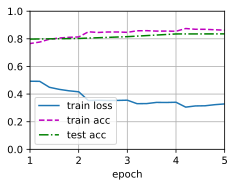

In [18]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net_glove.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net_glove, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [19]:
predict_sentiment(net_glove, vocab, 'this movie is so great')

'positive'

In [20]:
predict_sentiment(net_glove, vocab, 'this movie is so bad')

'negative'

FastText

In [41]:
net_fast = GRU(len(vocab), embed_size, num_hiddens, num_layers)

In [42]:
net_fast.apply(init_weights);
net_fast.embedding.weight.data.copy_(embeds_fast)
net_fast.embedding.weight.requires_grad = False

loss 0.499, train acc 0.755, test acc 0.770
189.5 examples/sec on [device(type='cuda', index=0)]


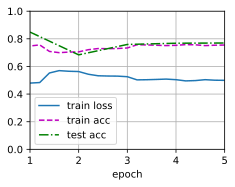

In [43]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net_fast.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net_fast, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [44]:
predict_sentiment(net_fast, vocab, 'this movie is so great')

'positive'

In [45]:
predict_sentiment(net_fast, vocab, "this movie is so bad")

'negative'

Word2Vec

In [46]:
net_word = GRU(len(vocab), embed_size, num_hiddens, num_layers)

In [47]:
net_word.apply(init_weights)
net_word.embedding.weight.data.copy_(embeds_word)
net_word.embedding.weight.requires_grad = False

loss 0.457, train acc 0.789, test acc 0.747
195.5 examples/sec on [device(type='cuda', index=0)]


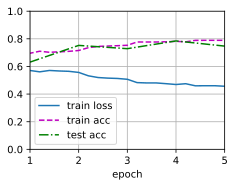

In [48]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net_word.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net_word, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [49]:
predict_sentiment(net_word, vocab, 'this movie is so great')

'positive'

In [50]:
predict_sentiment(net_word, vocab, "this movie is so bad")

'negative'

In [51]:
accuracy_glove = evaluate_accuracy(net_glove, test_iter, devices)
accuracy_fast = evaluate_accuracy(net_fast, test_iter, devices)
accuracy_word = evaluate_accuracy(net_word, test_iter, devices)
print(f'Accuracy with GloVe: {accuracy_glove:.4f}')
print(f'Accuracy with FastText: {accuracy_fast:.4f}')
print(f'Accuracy with FastText: {accuracy_word:.4f}')

Accuracy with GloVe: 0.8379
Accuracy with FastText: 0.7697
Accuracy with FastText: 0.7473


Test sentences

GLoVe

In [21]:
predict_sentiment(net_glove, vocab, "This movie made me pass a nice time but i don't know if i would recommend it")

'positive'

In [22]:
predict_sentiment(net_glove, vocab, "My mother liked this movie but my father didn't.")

'positive'

In [23]:
predict_sentiment(net_glove, vocab, "I only see you as a friend.")

'positive'

In [24]:
predict_sentiment(net_glove, vocab, "I got a 5 out of 10 in this subject")

'positive'

FastText

In [56]:
predict_sentiment(net_fast, vocab, "This movie made me pass a nice time but i don't know if i would recommend it")

'positive'

In [57]:
predict_sentiment(net_fast, vocab, "My mother liked this movie but my father didn't.")

'positive'

In [58]:
predict_sentiment(net_fast, vocab, "I only see you as a friend.")

'positive'

In [59]:
predict_sentiment(net_fast, vocab, "I got a 5 out of 10 in this subject")

'positive'

Word2vec

In [60]:
predict_sentiment(net_word, vocab, "This movie made me pass a nice time but i don't know if i would recommend it")

'positive'

In [61]:
predict_sentiment(net_word, vocab, "My mother liked this movie but my father didn't.")

'positive'

In [62]:
predict_sentiment(net_word, vocab, "I only see you as a friend.")

'positive'

In [63]:
predict_sentiment(net_word, vocab, "I got a 5 out of 10 in this subject")

'negative'